# Prioritized Replay Experiments

Default hyperparameters:

In [6]:
BUFFER_SIZE = int(100000) # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount rate
TAU = .001                # weight for soft update of target q-network parameters
LR = .0005                # learning rate for backprop
UPDATE_EVERY = 4          # number of time steps between backward passes on local q-network
eps=0.99                  # starting value for epsilon, the probability of randomly selecting an action  
decay=0.015               # the rate of decay in epsilon
min_eps=0.01              # minimum value of epsilon

## Baseline Solution

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

In [27]:
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
import timeit

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

In [35]:
class QNetwork(nn.Module):
    """Value function template"""
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y

In [12]:
class ReplayBuffer():
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object"""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from the memory buffer"""
        experiences = random.sample(self.memory, k=self.batch_size)
        # reshape and return experience components to device (CPU or GPU, set elsewhere)
        # from_numpy() creates pytorch tensor from numpy array
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def buffer_to_list(self):
        return list(self.memory)
    
    def __len__(self):
        """Return the current size of replay buffer memory"""
        return len(self.memory)

In [16]:
class Agent():
    def __init__(self, state_size, action_size, seed, eps=0.99, decay=0.015, min_eps=0.01):
        """Initialize the learning agent.
        
        params:
            decay: (0, 1] epsilon is multplied by (1 - decay) after each episode. 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.eps = eps
        self.decay = decay
        self.min_eps = min_eps
        
        #Initialize local and target q-networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        # Initialize optimizer to run gradient descent on local q-network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # LR is environment variable
        
        # Get experiences for training from replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0 # Time step counter
        self.replay_buffer = None
        
    def step(self, state, action, reward, next_state, done):
        # Save step to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        # Run learning cycle (backprop) every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Make sure there are enough samples in buffer to fill batch
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        # apply epsilon decay after each episode
        if done:
            self.eps = max(self.min_eps, self.eps * (1 - self.decay))
            # Save replay buffer to list
            self.replay_buffer = self.memory.buffer_to_list()
        
    def act(self, state):
        """Get policy action given current state"""
        # unsqueeze() returns new tensor with extra dimension inserted at position
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # put qnetwork_local in eval mode (disable gradient computations)
        self.qnetwork_local.eval()
        with torch.no_grad():
            # get inference
            action_values = self.qnetwork_local(state)
        # put qnetwork_local back in train mode
        self.qnetwork_local.train()
        
        # select epsilon-greedy action from inference values
        if random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update parameters of local qnetwork using backward pass"""
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values for next states from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local network
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def run_episode(agent):
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]            # get the current state
    state_size = len(state)
    score = 0  

    while True:
        # get next experience
        action = agent.act(state)                      # get policy-based action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        # add experience to replay buffer & learn every UPDATE_EVERY steps
        agent.step(state, action, reward, next_state, done) 

        # increment score
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            return score, agent.replay_buffer

In [9]:
def train_banana_agent(agent, n_episodes=500, max_t=2000):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        score, _ = run_episode(agent)
        scores.append(score)
        scores_window.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [39]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# update environment variables if desired


# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.01)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=500, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

Episode 100	Average Score: 1.48
Episode 200	Average Score: 6.94
Episode 300	Average Score: 11.05
Episode 377	Average Score: 13.01
Environment solved in 277 episodes!	Average Score: 13.01

training time: 300.1870413050001s


### Plot of Rewards per Episode

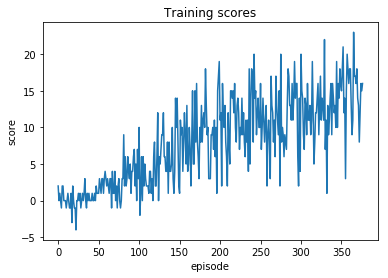

In [40]:
# Plot the score trend over episodes
plt.plot(scores)
plt.xlabel("episode")
plt.ylabel("score")
plt.title("Training scores")
plt.show()

Observations:
* The banana game trained fastest when exploration (epsilon) decayed quickly to a minimal level (1% exploration, 99% greedy action).

In [41]:
# save model weights
w = agent.qnetwork_local.parameters()

weights = []
for elem in w:
    weights.append(elem.detach().numpy())

with open('weights.pkl', 'wb') as f:
    pickle.dump(weights, f)

## Experiments with Prioritized Replay

Picking up a banana -- of either color -- is a relatively infrequent occurence in the banana game. Would prioritizing replay of pickup experiences improve learning?

First, let's measure how frequently an agent receives a non-zero reward.

In [20]:
def train_banana_agent(agent, n_episodes=350, max_t=2000):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        score, replay_buffer = run_episode(agent)
        scores.append(score)
        scores_window.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, replay_buffer

In [23]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.01)

start_time = timeit.default_timer()
scores1, replay_buffer_1 = train_banana_agent(agent, n_episodes=100)

Episode 100	Average Score: 0.90


The proportion of positive, negative and zero-valued rewards during play confirm that non-zero rewards are very infrequent events (<1%). 

In [24]:
rewards = []
buffers = [replay_buffer_1]
for buffer in buffers:
    r = [e[2] for e in buffer]
    rewards = rewards + r
negatives = rewards.count(-1)
positives = rewards.count(1)
zeros = rewards.count(0)
total = len(rewards)
print('{} ({:.1%}) negatives out of {} experiences'.format(negatives, negatives/total, total))
print('{} ({:.1%}) positives out of {} experiences'.format(positives, positives/total, total))
print('{} ({:.1%}) zeros out of {} experiences'.format(zeros, zeros/total, total))

56 (0.2%) negatives out of 30000 experiences
144 (0.5%) positives out of 30000 experiences
29799 (99.3%) zeros out of 30000 experiences


### 1. Prioritize Experiences with Positive and Negative Rewards

In [28]:
class ReplayBuffer():
    def __init__(self, action_size, buffer_size, batch_size, seed, p):
        """Initialize a ReplayBuffer object. Enable prioritized experience replay
        by creating separate buffers for neutral experiences (r==0) vs prioritized
        experiences (positive or negative reward)."""
        self.action_size = action_size
        self.prioritized_memory = deque(maxlen=buffer_size)
        self.neutral_memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.p = p #p=proportion of experiences to sample from prioritized memory
        self.check_batch_size_vs_proportion()
        
    class Error(Exception):
        pass
    
    class BatchProportionError(Error):
        pass        
        
    def check_batch_size_vs_proportion(self):
        try:
            if (self.p * self.batch_size) - int(self.p * self.batch_size) == 0:
                return
            else:
                raise BatchProportionError
        except:
            print('Invalid ReplayBuffer: Proportion of batch for prioritized replay must be a whole number (p * batch_size is integer).')
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to the appropriate buffer"""
        e = self.experience(state, action, reward, next_state, done)
        if self.p>0 and reward in [-1,1]:
            self.prioritized_memory.append(e) 
        else:
            self.neutral_memory.append(e)
            
        
    def sample(self):
        """Randomly sample a batch of experiences from the memory buffer"""
        if self.p>0:
            experiences = (
                random.sample(self.prioritized_memory, k=int(self.batch_size*self.p)) + 
                random.sample(self.neutral_memory, k=int(self.batch_size*(1-self.p)))           
            )
        else:
            experiences = random.sample(self.neutral_memory, k=self.batch_size)  
        random.shuffle(experiences)
        # reshape and return experience components to device (CPU or GPU, set elsewhere)
        # from_numpy() creates pytorch tensor from numpy array
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
#     def buffer_to_list(self, buffer):
#         return list(buffer)
    
    def __len__(self):
        """Return the current size of replay buffer memory"""
        return len(self.neutral_memory) + len(self.prioritized_memory)

Set up Agent Class to Implement Learning Process

In [30]:
class Agent():
    def __init__(self, state_size, action_size, seed, eps=0.99, decay=0.005, min_eps=0.05):
        """Initialize the learning agent.
        
        params:
            decay: (0, 1] epsilon is multplied by (1 - decay) after each episode. 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.eps = eps
        self.decay = decay
        self.min_eps = min_eps
        
        #Initialize local and target q-networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        # Initialize optimizer to run gradient descent on local q-network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # LR is environment variable
        
        # Get experiences for training from replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, P)
        self.t_step = 0 # Time step counter
        self.replay_buffer = None
        
    def step(self, state, action, reward, next_state, done):
        # Save step to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Run learning cycle (backprop) every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Make sure there are enough samples in buffer to fill batch
            if (len(self.memory.prioritized_memory) >= P * BATCH_SIZE and 
                len(self.memory.neutral_memory) >= (1-P) * BATCH_SIZE):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        # apply epsilon decay after each episode
        if done:
            self.eps = max(self.min_eps, self.eps * (1 - self.decay))
            # Save replay buffer to list
#             self.replay_buffer = self.memory.buffer_to_list()
        
    def act(self, state):
        """Get policy action given current state"""
        # unsqueeze() returns new tensor with extra dimension inserted at position
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # put qnetwork_local in eval mode (disable gradient computations)
        self.qnetwork_local.eval()
        with torch.no_grad():
            # get inference
            action_values = self.qnetwork_local(state)
        # put qnetwork_local back in train mode
        self.qnetwork_local.train()
        
        # select epsilon-greedy action from inference values
        if random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update parameters of local qnetwork using backward pass"""
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values for next states from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local network
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

Prioritized replay proportion P = 0.125

In [31]:
P = 0.125

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('training time: {}s'.format(elapsed))

Episode 100	Average Score: 0.06
Episode 200	Average Score: 1.05
Episode 300	Average Score: 2.56
Episode 350	Average Score: 3.05training time: 273.23979966800016s


Prioritized replay proportion P = 0.0625

In [32]:
P = 0.0625

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.05)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

Episode 100	Average Score: 0.10
Episode 200	Average Score: 0.342
Episode 300	Average Score: 0.68
Episode 350	Average Score: 1.19training time: 276.3147756540002s


No prioritization

In [ ]:
P = 0

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.05)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

Update less frequently

In [ ]:
UPDATE_EVERY = 12
P = 0

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.05)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

### 2. Prioritize positive rewards only

In [ ]:
class ReplayBuffer():
    def __init__(self, action_size, buffer_size, batch_size, seed, p):
        """Initialize a ReplayBuffer object. Enable prioritized experience replay
        by creating separate buffers for neutral experiences (r==0) vs prioritized
        experiences (positive or negative reward)."""
        self.action_size = action_size
        self.prioritized_memory = deque(maxlen=buffer_size)
        self.neutral_memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.p = p #p=proportion of experiences to sample from prioritized memory
        self.check_batch_size_vs_proportion()
        
    class Error(Exception):
        pass
    
    class BatchProportionError(Error):
        pass        
        
    def check_batch_size_vs_proportion(self):
        try:
            if (self.p * self.batch_size) - int(self.p * self.batch_size) == 0:
                return
            else:
                raise BatchProportionError
        except:
            print('Invalid ReplayBuffer: Proportion of batch for prioritized replay must be a whole number (p * batch_size is integer).')
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to the appropriate buffer"""
        e = self.experience(state, action, reward, next_state, done)
        if self.p>0 and reward>0:
            self.prioritized_memory.append(e)
        else:
            self.neutral_memory.append(e)
            
        
    def sample(self):
        """Randomly sample a batch of experiences from the memory buffer"""
        if self.p>0:
            experiences = (
                random.sample(self.prioritized_memory, k=int(self.batch_size*self.p)) + 
                random.sample(self.neutral_memory, k=int(self.batch_size*(1-self.p)))           
            )
        else:
            random.sample(self.neutral_memory, k=1)  
        random.shuffle(experiences)
        # reshape and return experience components to device (CPU or GPU, set elsewhere)
        # from_numpy() creates pytorch tensor from numpy array
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
#     def buffer_to_list(self, buffer):
#         return list(buffer)
    
    def __len__(self):
        """Return the current size of replay buffer memory"""
        return len(self.neutral_memory) + len(self.prioritized_memory)

In [ ]:
P = 0.125

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.05)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

In [ ]:
P = 0.0625

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, 
              eps=0.99, decay=0.015, min_eps=0.05)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

In [ ]:
P = 0.0

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0  

# create agent; initialize local and target q-network functions
agent = Agent(state_size=state_size, action_size=action_size, seed=561, eps=0.99, decay=0.015)

start_time = timeit.default_timer()
scores = train_banana_agent(agent=agent, n_episodes=350, max_t=2000)
elapsed = timeit.default_timer() - start_time
print('\ntraining time: {}s'.format(elapsed))

In [25]:
env.close()